In [1]:
#!/usr/bin/env python3.6
# -*- coding: utf-8 -*-

In [2]:
# Imports
import sys
import joblib
import numpy as np
from matplotlib import animation
from IPython.display import HTML
from matplotlib import pyplot as plt
import mpl_toolkits.mplot3d.axes3d as p3

In [3]:
#np.random.seed(20)
np.set_printoptions(threshold=sys.maxsize)

In [4]:
%matplotlib inline

In [5]:
%store -r X_footsteps_accelerations_absolute
%store -r Y_footsteps_accelerations_absolute
%store -r X_footsteps_continuous_absolute
%store -r Y_footsteps_continuous_absolute

#X_motion = np.concatenate((X_footsteps_accelerations_absolute, X_footsteps_continuous_absolute))
#Y_motion = np.concatenate((Y_footsteps_accelerations_absolute, Y_footsteps_continuous_absolute))

X_motion = X_footsteps_accelerations_absolute
Y_motion = Y_footsteps_accelerations_absolute

print(X_motion.shape)
print(Y_motion.shape)

(5387, 27)
(5387, 4)


# Multivariate Linear Regression (Foot prediction)

In [6]:
import sklearn
from sklearn import metrics
from sklearn.feature_selection import RFE
from sklearn.model_selection import KFold
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import PolynomialFeatures 
from sklearn.model_selection import cross_val_score, cross_val_predict
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score, accuracy_score

In [7]:
## Entries where FL is swinging
idxs = np.where(X_motion[:, -2] == 1)[0]
X_motion_FL_swinging = X_motion[idxs]
Y_motion_FL_swinging = Y_motion[idxs]

## Predict FL foot -> x

In [8]:
X_motion_FL_swinging[10]

array([ 0.1       ,  0.        ,  0.        ,  0.1       ,  0.        ,
        0.        ,  0.21840438,  0.13003148, -0.37701634,  0.25918305,
       -0.13256112, -0.3703649 , -0.23936759,  0.12442393, -0.38166779,
       -0.27998325, -0.12794775, -0.37933218,  0.14566456, -0.04575961,
        0.05389997,  0.06813524,  0.11354552, -0.01321472, -0.00481661,
        1.        ,  0.        ])

In [9]:
X_motion_FL_swinging[10, 18:22]

array([ 0.14566456, -0.04575961,  0.05389997,  0.06813524])

In [10]:
Y_motion_FL_swinging.shape

(2698, 4)

In [11]:
X_motion_FL_swinging[0:10, 0]

array([0.1, 0.1, 0. , 0. , 0.1, 0.1, 0.1, 0. , 0.1, 0. ])

### Linear Regression

In [101]:
# Input
X = np.hstack((X_motion_FL_swinging[:, :3], # Previous motion command
               X_motion_FL_swinging[:, 3:6], # Current motion command
               #X_motion_FL_swinging[:, 18:22], # Current CoM (x,y) veloctiy
               X_motion_FL_swinging[:, 6:8], # FL (x,y) position
               X_motion_FL_swinging[:, 9:11], # FR (x,y) position
               X_motion_FL_swinging[:, 12:14], # RL (x,y) position
               X_motion_FL_swinging[:, 15:17])) # RR (x, y) position

# Target
Y = np.array([Y_motion_FL_swinging[:, 0]]).T

assert Y.shape[0] == X.shape[0]

# Split data into train and test set
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, train_size = 0.9, shuffle=True, random_state=100)

# Create the model
model_fl_relative_support_x = LinearRegression()

# Fit the model
model_fl_relative_support_x.fit(X_train, Y_train)
    
# Predict
predictions = model_fl_relative_support_x.predict(X_test)

# Stats
print('R2: ', r2_score(predictions, Y_test))
print('RMSE: ', np.sqrt(mean_squared_error(Y_test, predictions)))
print("The lowest error is: ", np.min(np.abs(predictions - Y_test)))
print("The highest error is: ", np.max(np.abs(predictions - Y_test)))
print("The avg. error is: ", np.mean(np.abs(predictions - Y_test)))
#print("Seq of errors (descendant): \n", sorted(np.abs(predictions - Y_test).tolist(), reverse=True))

R2:  0.9801645516085898
RMSE:  0.021787756629980014
The lowest error is:  2.65808669870915e-05
The highest error is:  0.10570480548886413
The avg. error is:  0.015895408044487035


In [102]:
model_fl_relative_support_x.coef_

array([[ 4.20600309e-02, -5.55111512e-16, -1.11022302e-16,
         2.06952476e-01, -2.22044605e-16,  2.22044605e-16,
         3.17740200e-01, -1.42997682e+00, -1.28564077e-01,
         2.34331471e+00,  6.11250579e-01,  1.97573088e-01,
        -2.38618624e+00, -2.55289131e-01]])

In [103]:
model_fl_relative_support_x.intercept_

array([-0.07062906])

Text(0, 0.5, 'Predictions')

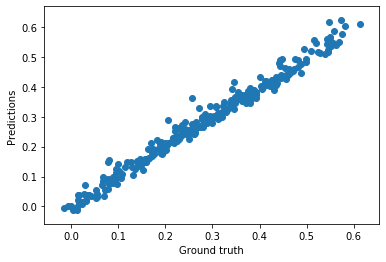

In [104]:
## The line / model
plt.scatter(Y_test, predictions)
plt.xlabel("Ground truth")
plt.ylabel("Predictions")

In [105]:
#for idx, prediction in enumerate(predictions):
#    print(f'Start: {X_test[idx, 6]}. Groundtruth: {Y_test[idx]}. Predicted: {prediction}')

### Predict FL foot -> y

In [109]:
# Input
X = np.hstack((X_motion_FL_swinging[:, :3], # Previous motion command
               X_motion_FL_swinging[:, 3:6], # Current motion command
               #X_motion_FL_swinging[:, 18:22], # Current CoM (x,y) veloctiy
               X_motion_FL_swinging[:, 6:8], # FL (x,y) position
               X_motion_FL_swinging[:, 9:11], # FR (x,y) position
               X_motion_FL_swinging[:, 12:14], # RL (x,y) position
               X_motion_FL_swinging[:, 15:17])) # RR (x, y) position

# Target
Y = np.array([Y_motion_FL_swinging[:, 1]]).T

assert Y.shape[0] == X.shape[0]

# Split data into train and test set
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, train_size = 0.9, shuffle=True, random_state=100)

# Create the model
model_fl_relative_support_y = LinearRegression()

# Fit the model
model_fl_relative_support_y.fit(X_train, Y_train)

# Predict
predictions = model_fl_relative_support_y.predict(X_test)

# Stats
print('R2: ', r2_score(predictions, Y_test))
print('RMSE: ', np.sqrt(mean_squared_error(Y_test, predictions)))
print("The lowest error is: ", np.min(np.abs(predictions - Y_test)))
print("The highest error is: ", np.max(np.abs(predictions - Y_test)))
print("The avg. error is: ", np.mean(np.abs(predictions - Y_test)))
#print("Seq of errors (descendant): \n", sorted(np.abs(predictions - Y_test).tolist(), reverse=True))

R2:  0.5228773585873615
RMSE:  0.007372604288931409
The lowest error is:  6.490749019941178e-06
The highest error is:  0.03478265325668713
The avg. error is:  0.0056291139927113236


In [110]:
model_fl_relative_support_y.coef_

array([[-8.70312999e-04,  2.16840434e-17,  9.71445147e-17,
         1.25034194e-02,  1.11022302e-16,  0.00000000e+00,
         3.26485833e-01, -1.38608334e+00,  1.56238251e-01,
         7.70901464e-01, -2.30168468e-01,  2.78559425e-01,
        -4.94983307e-01, -4.44662655e-01]])

In [111]:
model_fl_relative_support_y.intercept_

array([-0.11971733])

Text(0, 0.5, 'Predictions')

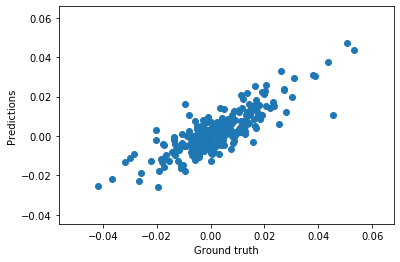

In [112]:
## The line / model
plt.scatter(Y_test, predictions)
plt.xlabel("Ground truth")
plt.ylabel("Predictions")

In [86]:
#for idx, prediction in enumerate(predictions):
#    print(f'Groundtruth: {Y_test[idx]}. Predicted: {prediction}')